# Convolutional Neural Network for Aerial Cactus Identification
This notebook demonstrates training a CNN model to classify aerial images of terrain as containing a cactus or not. Key steps include:
- Loading and preprocessing training images
- Create a balanced dataset
- Defining CNN model architecture  
- Evaluating model performance
- Making predictions on test images

# Loading and preprocessing training images

In [1]:
# Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import AUC, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import array_to_img

2024-05-02 00:43:29.263119: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-02 00:43:29.263258: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-02 00:43:29.574016: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def prepareImages(data, m, dataset, i=150, j=150, depth=1):
    """Load images and convert to numpy array.
    
    Args:
        data (DataFrame): Contains image ids to load.
        m (int): Number of images. 
        dataset (str): Path to image directory.
        i (int): Target image width.
        j (int): Target image height.  
        depth (int): Color channels (1 for grayscale, 3 for RGB).

    Returns:
        numpy.array: Images loaded into array of shape (m, i, j, depth).
    """
    print(f"Preparing {m} images from {dataset} directory, resized to {i}x{j}...")
    X = np.zeros((m, i, j, depth))
    for idx, image_id in enumerate(data['id']):
        img = Image.open(f"{dataset}/{image_id}").resize((i, j))
        if depth == 1:
            img = img.convert('L')
        X[idx] = np.array(img)
        if idx % 500 == 0:
            print(f"Loaded {idx+1}/{m} images")
    return X

In [3]:
def add_conv_block(model, filters, size, stride, padding='same'):
    """Add a convolutional block to the model"""
    model = Conv2D(filters, size, strides=stride, padding=padding, activation='relu')(model)
    model = MaxPooling2D(pool_size=2)(model) 
    model = BatchNormalization(axis=3)(model)
    model = Dropout(0.2)(model)
    return model

def build_model(input_shape, num_classes):
    """Define model architecture"""
    print(f"Building model for input shape {input_shape} and {num_classes} classes")
    inputs = Input(shape=input_shape)
    
    model = BatchNormalization(axis=3)(inputs)
    
    model = add_conv_block(model, 48, 5, 1)
    model = add_conv_block(model, 64, 5, 1)  
    model = add_conv_block(model, 128, 5, 1)
    model = add_conv_block(model, 160, 5, 1)
    model = add_conv_block(model, 192, 5, 1)

    model = Flatten()(model)
    outputs = Dense(num_classes, activation='sigmoid')(model)
    
    return Model(inputs=inputs, outputs=outputs)

In [4]:
def plot_history(history):
    """Plot training history"""
    print("Training history:")
    for metric, values in history.items():
        if not metric.startswith('val_'):
            print(f"{metric}: min={min(values):.4f}, max={max(values):.4f}")
            
    metrics = list(history.keys())
    num_metrics = len(metrics) // 2 + 1
    num_cols = 3
    num_rows = (num_metrics + num_cols - 1) // num_cols
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(24, 16))
    axes = axes.flatten()
    
    for i, metric in enumerate(metrics):
        if not metric.startswith('val_'):
            ax = axes[i]
            ax.plot(history[metric], marker='o')
            if metric != 'lr':
                ax.plot(history[f'val_{metric}'], marker='o')
            ax.set_title(metric)
            ax.set_xlabel('Epoch')
            ax.legend(['Train', 'Val'], loc='upper right')
            ax.grid()

In [5]:
  import os
os.listdir('/kaggle/input')


# Load training data
train_df = pd.read_csv('../input/train.csv')
width, height, depth = 32, 32, 3
num_classes = 1
batch_size = 16
epochs = 50

In [6]:
# Load and preprocess images  
X = prepareImages(train_df, train_df.shape[0], "../input/train/train", width, height, depth)

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, train_df['has_cactus'], test_size=0.1, random_state=4)

Preparing 17500 images from /kaggle/input/aerial-cactus/train/train directory, resized to 32x32...
Loaded 1/17500 images
Loaded 501/17500 images
Loaded 1001/17500 images
Loaded 1501/17500 images
Loaded 2001/17500 images
Loaded 2501/17500 images
Loaded 3001/17500 images
Loaded 3501/17500 images
Loaded 4001/17500 images
Loaded 4501/17500 images
Loaded 5001/17500 images
Loaded 5501/17500 images
Loaded 6001/17500 images
Loaded 6501/17500 images
Loaded 7001/17500 images
Loaded 7501/17500 images
Loaded 8001/17500 images
Loaded 8501/17500 images
Loaded 9001/17500 images
Loaded 9501/17500 images
Loaded 10001/17500 images
Loaded 10501/17500 images
Loaded 11001/17500 images
Loaded 11501/17500 images
Loaded 12001/17500 images
Loaded 12501/17500 images
Loaded 13001/17500 images
Loaded 13501/17500 images
Loaded 14001/17500 images
Loaded 14501/17500 images
Loaded 15001/17500 images
Loaded 15501/17500 images
Loaded 16001/17500 images
Loaded 16501/17500 images
Loaded 17001/17500 images


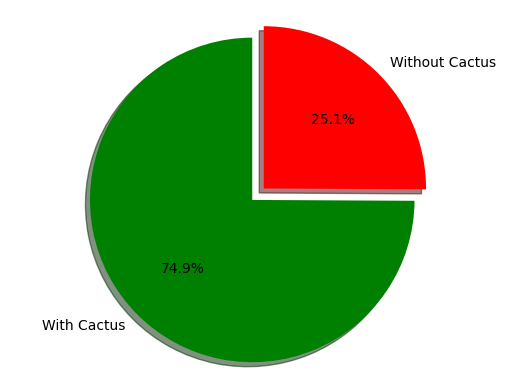

In [7]:
# Dataset details
labels = 'With Cactus', 'Without Cactus'
sizes = [11799, 15750 - 11799] 
colors = ['green', 'red']
explode = (0.1, 0)  

# Create a pie chart
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.show()

# Create a balanced dataset

In [8]:
#Oversampling
import cv2
import numpy as np

def add_noise(img,variance=0.1,mean=0):
    """add gaussian noise to an image"""
    noise = np.random.normal(mean, variance, img.shape)
    img += noise
    img = np.clip(img, 0., 1.)
    return img

def rotation(img, angle=90):
    """rotate an image by a given angle in degrees"""
    return np.rot90(img, k=angle//90)

def luminosity(img, factor=1):
    """change the luminosity of an image"""
    return np.clip(img * factor, 0., 1.)


def random_zoom(img, min_factor=0.5, max_factor=1.5):
    """Apply random zooming within a range to an image."""
    if min_factor >= max_factor:
        raise ValueError("min_factor must be less than max_factor")
    
    # Générer un facteur de zoom aléatoire entre min_factor et max_factor
    factor = np.random.uniform(min_factor, max_factor)
    h, w = img.shape[:2]
    new_h = int(h * factor)
    new_w = int(w * factor)
    
    if factor < 1.0:
        # Pour un facteur de zoom inférieur à 1, nous effectuons un crop aléatoire
        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)
        cropped = img[top:top + new_h, left:left + new_w]
        img = cv2.resize(cropped, (w, h), interpolation=cv2.INTER_LINEAR)
    else:
        # Pour un facteur de zoom supérieur à 1, nous agrandissons l'image
        resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
        # S'assurer que la zone à cropper existe encore
        top = np.random.randint(0, max(1, new_h - h))
        left = np.random.randint(0, max(1, new_w - w))
        img = resized[top:top + h, left:left + w]

    return img


def oversampling(df, n):
    """Oversampling the dataframes df with adding n images"""
    new_df=[]
    for i in range(n):
        img_random=df[np.random.randint(0, len(df))].copy()
        if np.random.rand() < 0.5:
            img_random = rotation(img_random, angle=np.random.choice([90, 180, 270]))
        if np.random.rand() < 0.5:
            img_random = luminosity(img_random, factor=np.random.uniform(0.5, 1.5))
        if np.random.rand() < 0.5:
            img_random = add_noise(img_random, variance=np.random.uniform(0, 0.05))
        if np.random.rand() < 0.5:
            img_random = random_zoom(img_random, min_factor=0.5, max_factor=1.5)
        new_df.append(img_random)
    new_df=np.array(new_df)
    return new_df

def normalize(X):
    """Normalize the data assuming X can be a single image (3D) or multiple images (4D)."""
    # Convert to float32 for precision and perform normalization
    return X.astype('float32') / 255.0
     

In [9]:
X_train_noCactus = X_train[y_train == 0]

#normalization
X_train_noCactus=normalize(X_train_noCactus)

#oversampling
n=len(y_train[y_train == 1])-len(y_train[y_train == 0])
X_train_noCactus=oversampling(X_train_noCactus,n)
y_train_noCactus=np.zeros(n)

print("Total of images",len(X_train_noCactus),",and number of images with cactus",y_train_noCactus.sum())

Total of images 7848 ,and number of images with cactus 0.0


In [10]:
#add the new images to the training set
X_train=np.concatenate((X_train,X_train_noCactus))
y_train=np.concatenate((y_train,y_train_noCactus))

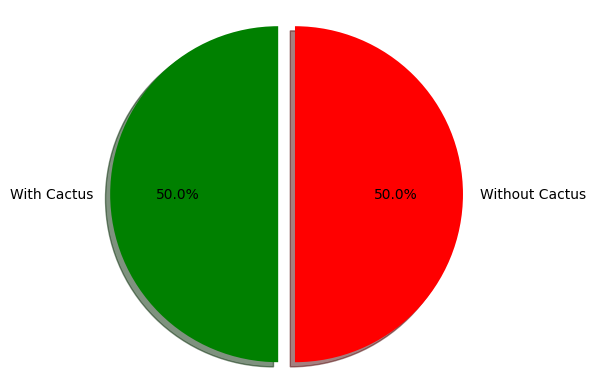

In [11]:
#check if the data is balanced
labels = 'With Cactus', 'Without Cactus'
sizes = [y_train.sum(), len(X_train) - y_train.sum()]  
colors = ['green', 'red']
explode = (0.1, 0) 

# Creation of the pie chart
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  
plt.show()

# Defining CNN model architecture 

In [12]:
# Build model
model = build_model((width, height, depth), num_classes)
model.summary()

Building model for input shape (32, 32, 3) and 1 classes


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 3)      │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 48)     │         3,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 48)     │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        76,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 160)      │       512,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 160)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 2, 2, 160)      │           640 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2, 2, 160)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 2, 2, 192)      │       768,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 1, 1, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 1, 1, 192)      │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1, 1, 192)      │             

 Total params: 1,568,365 (5.98 MB)

 Trainable params: 1,567,175 (5.98 MB)

 Non-trainable params: 1,190 (4.65 KB)

In [13]:
# Compile model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[AUC(name='auc'), Precision(name='precision'), Recall(name='recall')]
)

# Set up data augmentation 
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)
aug.fit(X_train)

# Evaluating model performance

In [14]:
# Train model
history = model.fit(
    aug.flow(X_train, y_train, batch_size=batch_size),
    epochs=epochs, 
    validation_data=(X_val, y_val)
)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  14/1475 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - auc: 0.8080 - loss: 0.8451 - precision: 0.7582 - recall: 0.8163

I0000 00:00:1714610764.067266      70 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1475/1475 ━━━━━━━━━━━━━━━━━━━━ 53s 23ms/step - auc: 0.9674 - loss: 0.2323 - precision: 0.9078 - recall: 0.9193 - val_auc: 0.9933 - val_loss: 0.1124 - val_precision: 0.9528 - val_recall: 0.9963
Epoch 2/50
1475/1475 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - auc: 0.9885 - loss: 0.1300 - precision: 0.9523 - recall: 0.9550 - val_auc: 0.9967 - val_loss: 0.0630 - val_precision: 0.9730 - val_recall: 0.9955
Epoch 3/50
1475/1475 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - auc: 0.9913 - loss: 0.1131 - precision: 0.9576 - recall: 0.9611 - val_auc: 0.9985 - val_loss: 0.0493 - val_precision: 0.9873 - val_recall: 0.9910
Epoch 4/50
1475/1475 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - auc: 0.9941 - loss: 0.0914 - precision: 0.9687 - recall: 0.9689 - val_auc: 0.9989 - val_loss: 0.0359 - val_precision: 0.9910 - val_recall: 0.9903
Epoch 5/50
1475/1475 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - auc: 0.9952 - loss: 0.0799 - precision: 0.9716 - recall: 0.9730 - val_auc: 0.9990 - val_loss: 0.0370 - val_precision: 0.9932 - val_recall

Training history:
auc: min=0.9790, max=0.9997
loss: min=0.0140, max=0.1841
precision: min=0.9259, max=0.9962
recall: min=0.9338, max=0.9952


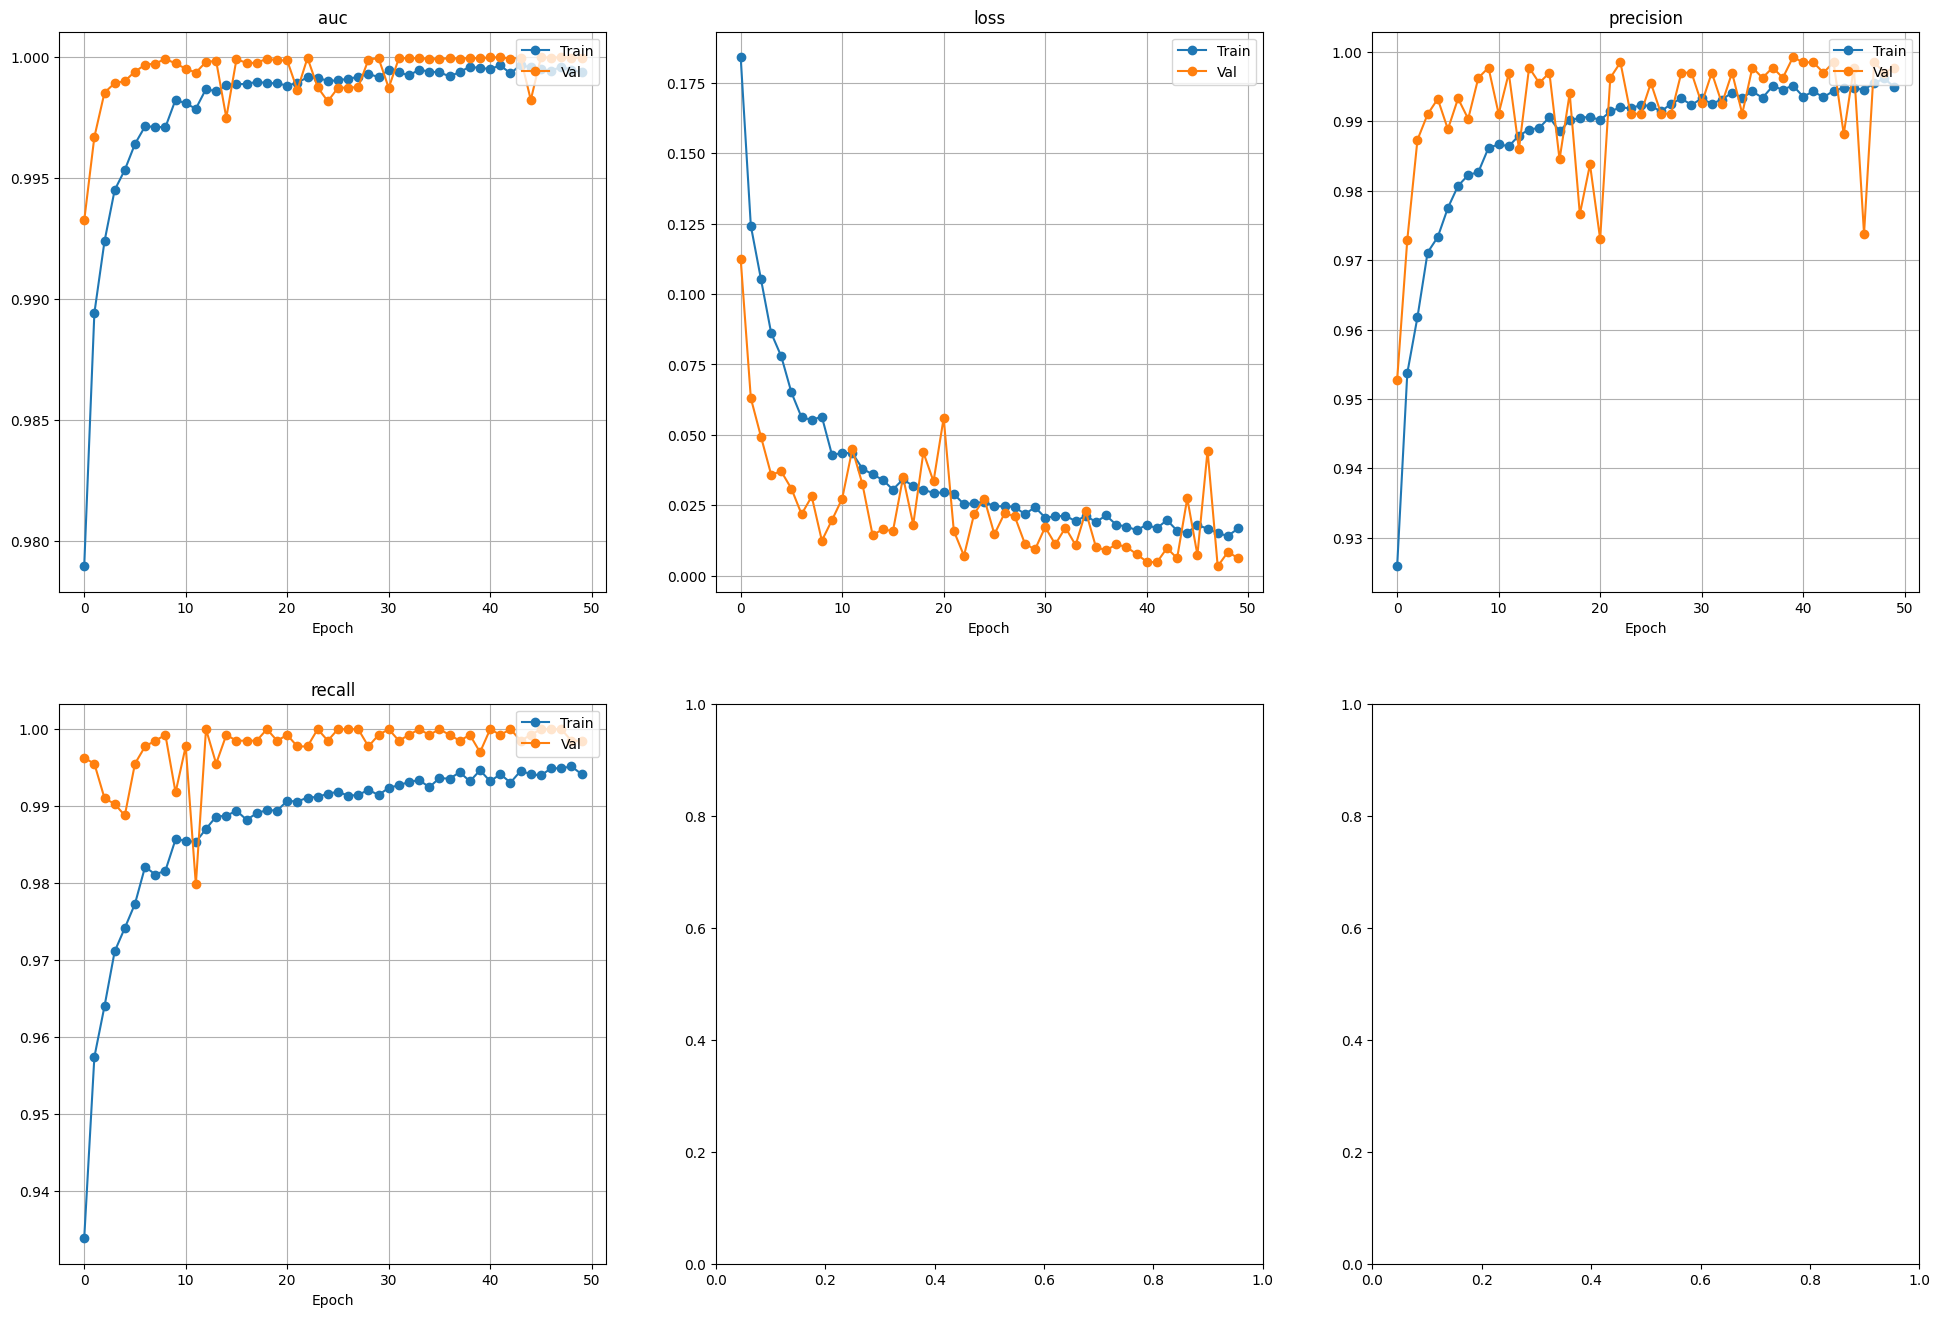

In [15]:
# Plot training history
plot_history(history.history)

In [16]:
# Extract the metrics from the history dictionary
loss = history.history['loss']
val_loss = history.history['val_loss']
auc = history.history['auc']
val_auc = history.history['val_auc']

# Create a list of the desired epochs
epochs = [0, 10, 20, 30, 40, 49]

# Create a DataFrame to store the metrics
metrics_table = pd.DataFrame({
    'Epoch': epochs,
    'Loss': [loss[e] if e < len(loss) else 'N/A' for e in epochs],
    'Val_Loss': [val_loss[e] if e < len(val_loss) else 'N/A' for e in epochs],
    'ROC_AUC': [auc[e] if e < len(auc) else 'N/A' for e in epochs],
    'Val_ROC_AUC': [val_auc[e] if e < len(val_auc) else 'N/A' for e in epochs]
})

# Display the table
print(metrics_table)

   Epoch      Loss  Val_Loss   ROC_AUC  Val_ROC_AUC
0      0  0.184121  0.112355  0.978965     0.993252
1     10  0.043556  0.027310  0.998091     0.999526
2     20  0.029552  0.055989  0.998823     0.999863
3     30  0.020568  0.017187  0.999473     0.998730
4     40  0.018005  0.004943  0.999518     0.999993
5     49  0.016717  0.006217  0.999381     0.999979


55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


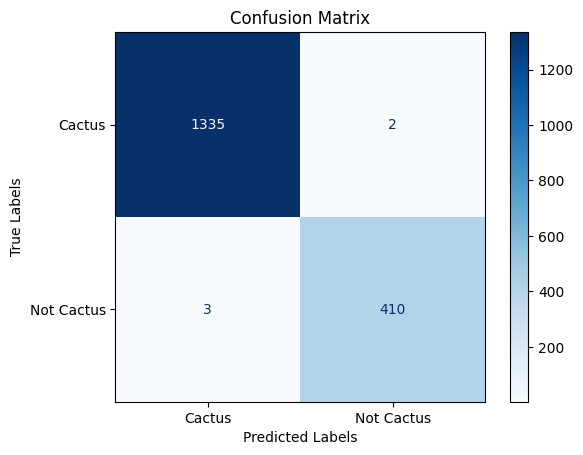

In [17]:
# Compute the confusion matrix
y_pred = model.predict(X_val)
y_pred = (y_pred > 0.5).astype(int)

# Get the unique labels from the train_df
labels = train_df.iloc[:, 1].unique()

# Create a dictionary to map labels to their corresponding names
label_names = {0: 'Not Cactus', 1: 'Cactus'}

# Generate the confusion matrix
cm = confusion_matrix(y_val, y_pred, labels=labels)

# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[label_names[label] for label in labels])

# Plot the confusion matrix
disp.plot(cmap='Blues')

# Add labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


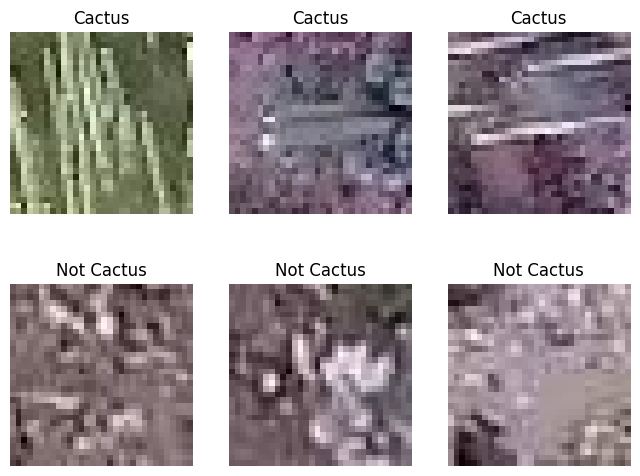

In [18]:
# Initialize lists to hold indices for each class
cactus_indices = []
no_cactus_indices = []

# Randomly select indices for each class until you have 3 of each
while len(cactus_indices) < 3 or len(no_cactus_indices) < 3:
    # Generate a random index within the valid range of y_val
    index = np.random.randint(0, len(y_val))
    
    # Use .iloc to safely access the element by integer location
    label = y_val.iloc[index]
    
    # Check the label of the image at the generated index
    if label == 1 and len(cactus_indices) < 3:
        cactus_indices.append(index)
    elif label == 0 and len(no_cactus_indices) < 3:
        no_cactus_indices.append(index)

# Combine the indices
selected_indices = cactus_indices + no_cactus_indices

# Select the images using the combined indices
selected_images = X_val[selected_indices]

# Predict labels for the selected images
predicted_labels = model.predict(selected_images)
predicted_labels = (predicted_labels > 0.5).astype(int)

# Plot the images with their predicted labels
fig, axes = plt.subplots(2, 3, figsize=(8, 6))
for i, ax in enumerate(axes.flat):
    # Convert the image back to its original form if necessary
    img = array_to_img(selected_images[i])
    
    # Plot the image
    ax.imshow(img)
    ax.axis('off')
    
    # Add title indicating whether the image contains a cactus or not
    if predicted_labels[i] == 1:
        ax.set_title('Cactus')
    else:
        ax.set_title('Not Cactus')

plt.show()

# Making predictions on test images

In [19]:
# Load and preprocess test images
test_df = pd.DataFrame({'id': os.listdir("../input/test/test/")}) 
X_test = prepareImages(test_df, test_df.shape[0], "../input/test/test/", width, height, depth)

# Make predictions on test images
preds = model.predict(X_test)
preds = (preds > 0.5).astype(int)

# Save predictions to CSV
output_df = pd.DataFrame({'id': test_df['id'], 'has_cactus': preds.flatten()})
output_df.to_csv('submission.csv', index=False)
print("Predictions saved to submission.csv")

Preparing 4000 images from /kaggle/input/aerial-cactus/test/test/ directory, resized to 32x32...
Loaded 1/4000 images
Loaded 501/4000 images
Loaded 1001/4000 images
Loaded 1501/4000 images
Loaded 2001/4000 images
Loaded 2501/4000 images
Loaded 3001/4000 images
Loaded 3501/4000 images
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Predictions saved to submission.csv


# Reference
- Angrew Ng & Coursera - https://www.coursera.org/learn/machine-learning
- Anezka Kolaceke - https://www.kaggle.com/anezka/cnn-with-keras-for-humpback-whale-id
- Peter - https://www.kaggle.com/pestipeti/keras-cnn-starter
- Yassine Ghouzam, PhD - https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6
- Martin Piotte - https://www.kaggle.com/martinpiotte/bounding-box-model